In [1]:
import pyfiles.HFSAnalyzer as HFSA

import os
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
from imp import reload
import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
import matplotlib.gridspec as gridspec

pwd = os.getcwd()

In [2]:
sns.set_context('paper')
sns.set_style('white')
sns.set_palette('colorblind')
%matplotlib inline

alpha = 0.9   # Change from RGB colors to RGBA with this alpha value
mycolors = np.asarray(sns.color_palette())
zeros = alpha * np.ones(len(mycolors))
mycolors = np.hstack([mycolors, zeros[:, None]])


rc['text.usetex'] = True
rc['font.size'] = 30
rc['figure.figsize'] = (5, 5)
rc['savefig.format'] = 'pdf'
rc['savefig.transparent'] = True
rc['savefig.bbox'] = 'tight'
rc['savefig.directory'] = os.chdir(pwd + '/../doc/images')

In [3]:
# load and scrub data
workdir = '/home/evan/git/HF-Stability/analysis/'
df =  HFSA.json_dir_to_df(workdir + 'log')

df.dropna(axis='rows', subset=['NDIM', 'rs', 'Nk', 'mycase', 'dav_min_eval'], inplace=True)
df['Nk'] = df['Nk'].astype(int)
df['NDIM'] = df['NDIM'].astype(int)
df['mycase'] = df['mycase'].astype(str)

In [4]:
# Split into groups
def dict_subview(dic, keys):
    return {key : val for (key, val) in dic.items() if key in keys}

data = {
     'all'   : df
    ,'3D'    : df[df['NDIM'] == 3]
    ,'2D'    : df[df['NDIM'] == 2]
    ,'3Drs12': df[np.isclose(df['rs'].as_matrix(), 1.2) & (df['NDIM'] == 3)]
    ,'2Drs12': df[np.isclose(df['rs'].as_matrix(), 1.2) & (df['NDIM'] == 2)]
    
    ,'3DR2R' : df[((df.mycase.str.contains('cRHF2cRHF')) & (df['NDIM'] == 3))]    
    ,'3DR2U' : df[((df.mycase.str.contains('cRHF2cUHF')) & (df['NDIM'] == 3))]
    ,'3DR2G' : df[((df.mycase.str.contains('cRHF2cGHF')) & (df['NDIM'] == 3))]
    ,'3DU2U' : df[((df.mycase.str.contains('cUHF2cUHF')) & (df['NDIM'] == 3))]

    ,'2DR2R' : df[((df.mycase.str.contains('cRHF2cRHF')) & (df['NDIM'] == 2))]    
    ,'2DR2U' : df[((df.mycase.str.contains('cRHF2cUHF')) & (df['NDIM'] == 2))]
    ,'2DR2G' : df[((df.mycase.str.contains('cRHF2cGHF')) & (df['NDIM'] == 2))]
    ,'2DU2U' : df[((df.mycase.str.contains('cUHF2cUHF')) & (df['NDIM'] == 2))]
    
    ,'1DR2R' : df[((df.mycase.str.contains('cRHF2cRHF')) & (df['NDIM'] == 1))]
    ,'1DR2U' : df[((df.mycase.str.contains('cRHF2cUHF')) & (df['NDIM'] == 1))]
}

# remove emptys
data = {key: val for (key, val) in data.items() if len(val) > 0}

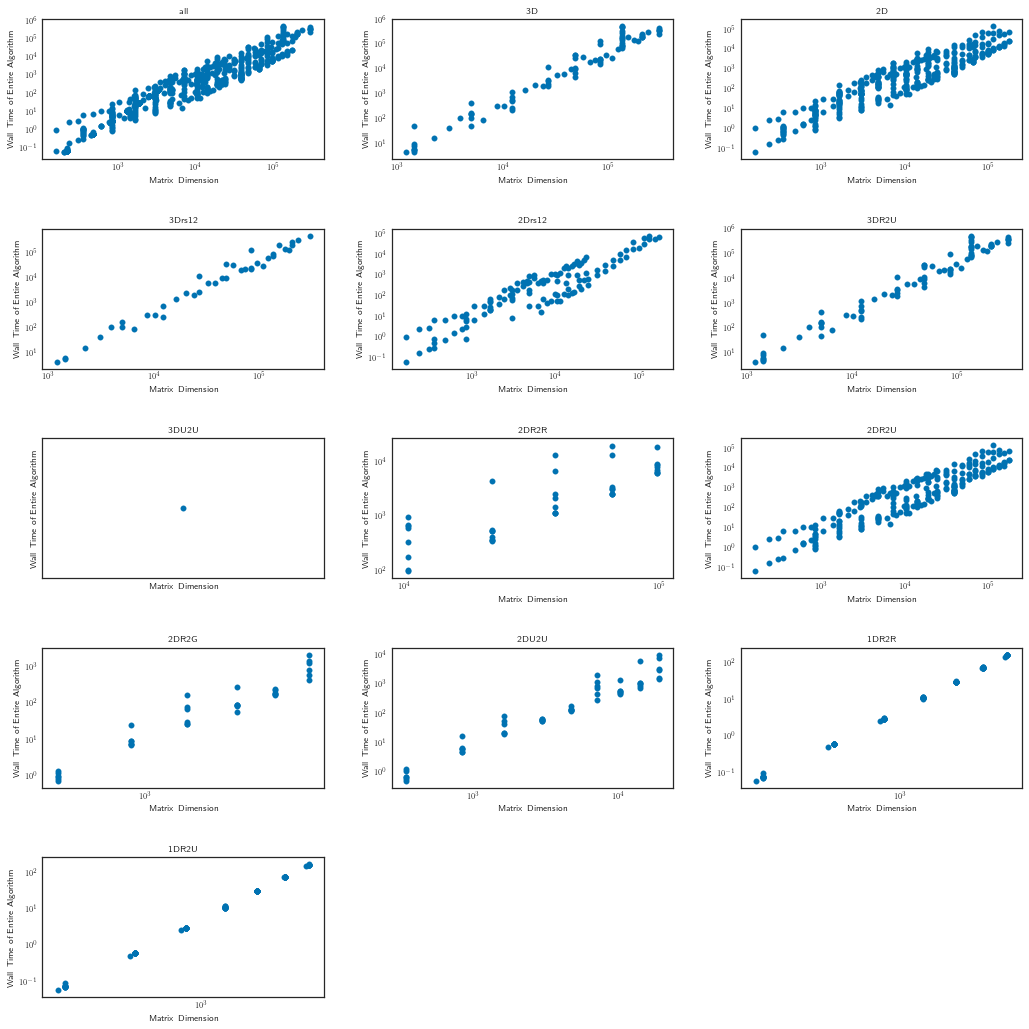

In [5]:
fig = plt.figure(figsize=(15, 15))
HFSA.subplotByDfDict(data, fig, HFSA.plot_runtime)
plt.tight_layout()
plt.show()

/home/evan/git/HF-Stability/analysis/pyfiles/HFSAnalyzer.py:423: RuntimeWarning: divide by zero encountered in log10
  c = np.polyfit(np.log10(Nmatfull)[-10:], np.log10(fulltimes)[-10:], 1)
/home/evan/git/HF-Stability/analysis/pyfiles/HFSAnalyzer.py:430: RuntimeWarning: divide by zero encountered in log10
  cdav = np.polyfit(np.log10(Nmat), np.log10(Davtimes), 1)
/home/evan/git/HF-Stability/analysis/pyfiles/HFSAnalyzer.py:430: RankWarning: Polyfit may be poorly conditioned
  cdav = np.polyfit(np.log10(Nmat), np.log10(Davtimes), 1)


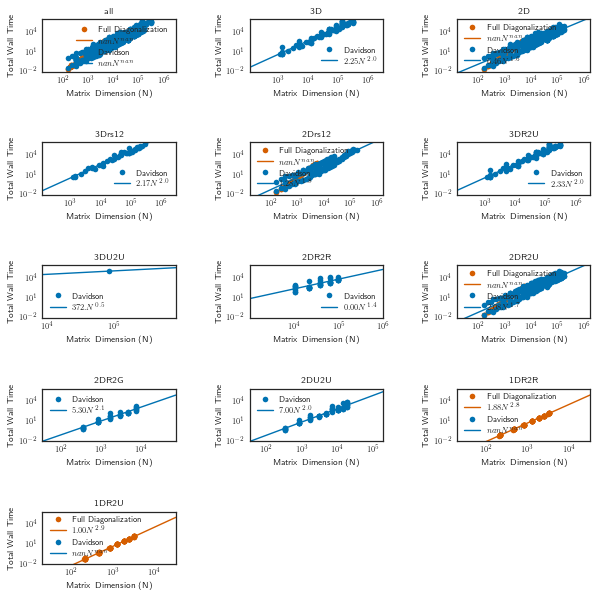

In [6]:
fig = plt.figure(figsize=(9, 9))
HFSA.subplotByDfDict(data, fig, HFSA.plot_diag_scaling)
plt.tight_layout()
plt.show()

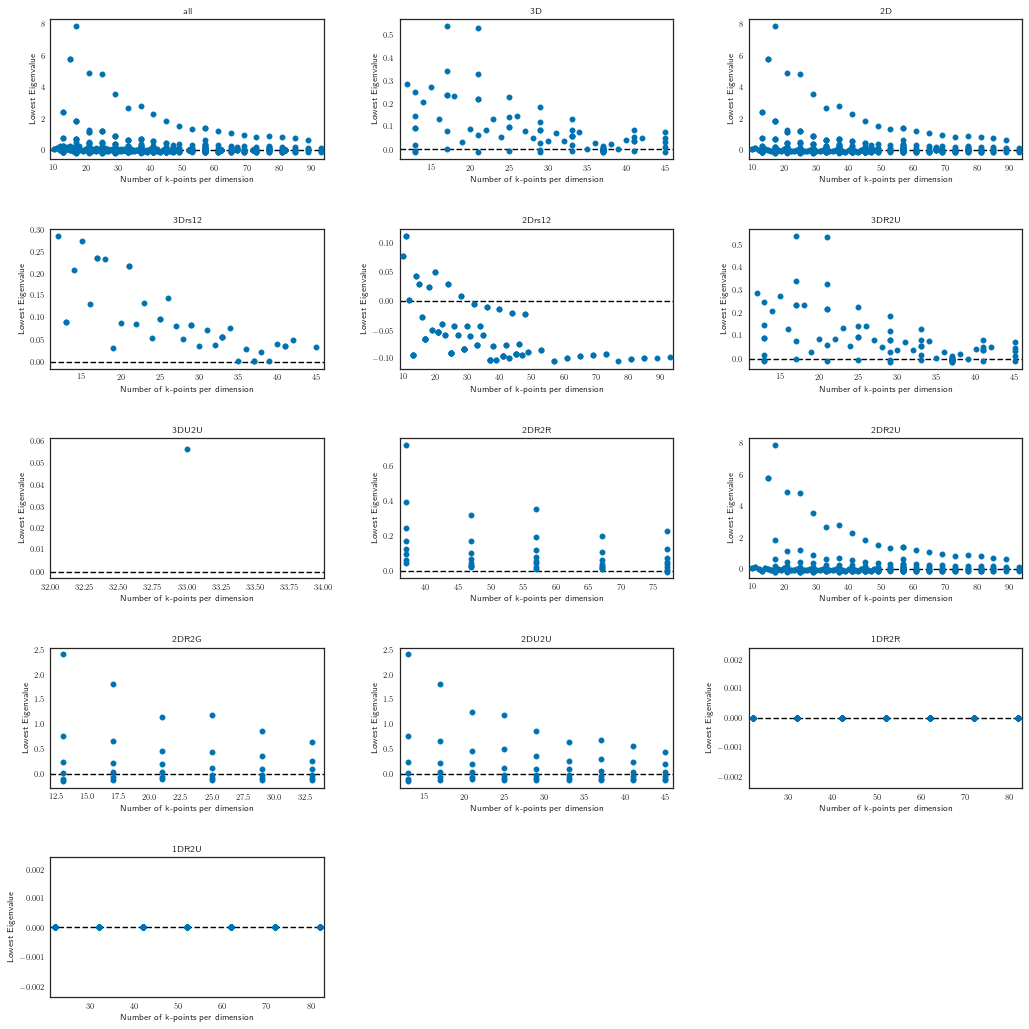

In [7]:
fig = plt.figure(figsize=(15, 15))
HFSA.subplotByDfDict(data, fig, HFSA.plot_dav_vs_full)
plt.tight_layout()
plt.show()

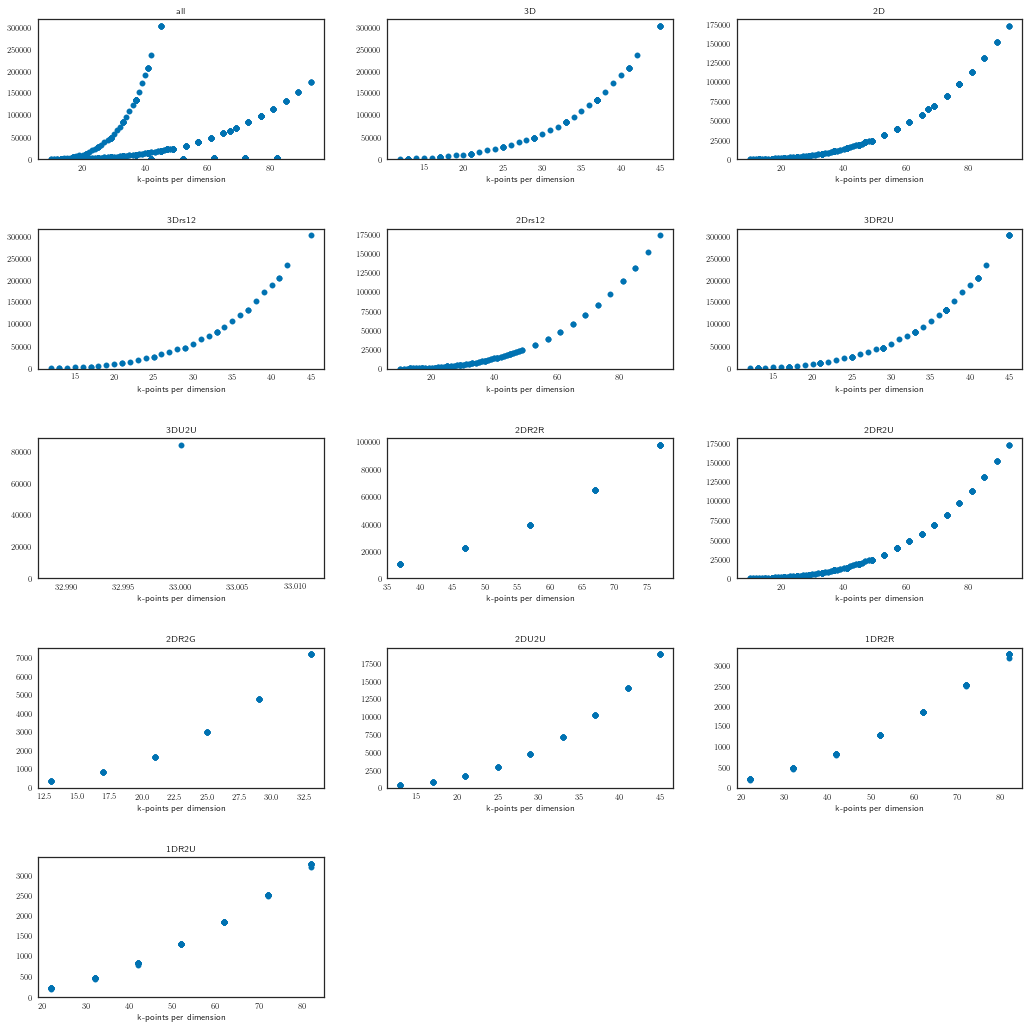

In [8]:
fig = plt.figure(figsize=(15,15))
HFSA.subplotByDfDict(data, fig, HFSA.plot_matrix_scaling)
plt.tight_layout()
plt.show()

/home/evan/git/HF-Stability/analysis/pyfiles/HFSAnalyzer.py:365: RuntimeWarning: divide by zero encountered in log10
  c = np.polyfit(np.log10(x_split), np.log10(mvtimes_split),  1)
/home/evan/local/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


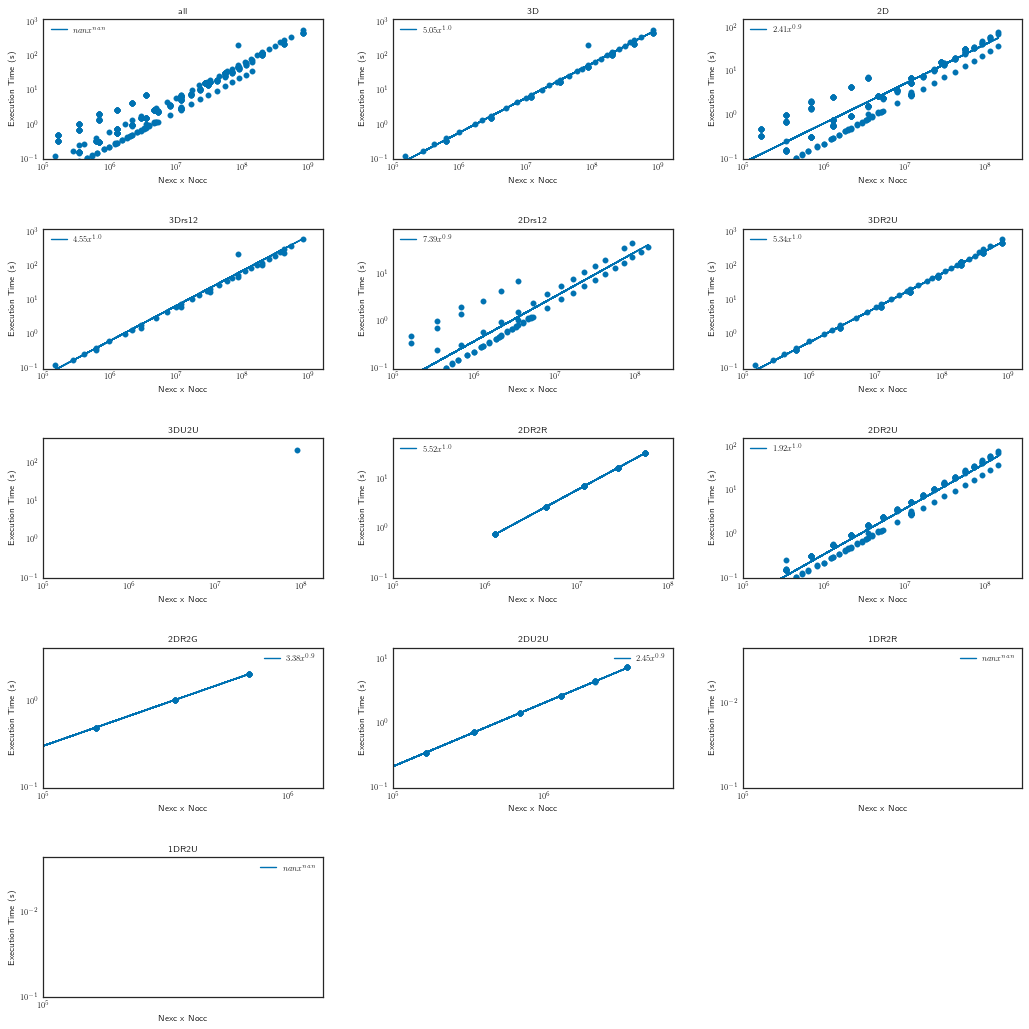

In [9]:
fig = plt.figure(figsize=(15, 15))
HFSA.subplotByDfDict(data, fig, HFSA.plot_mvproduct_scaling)
plt.tight_layout()
plt.show()

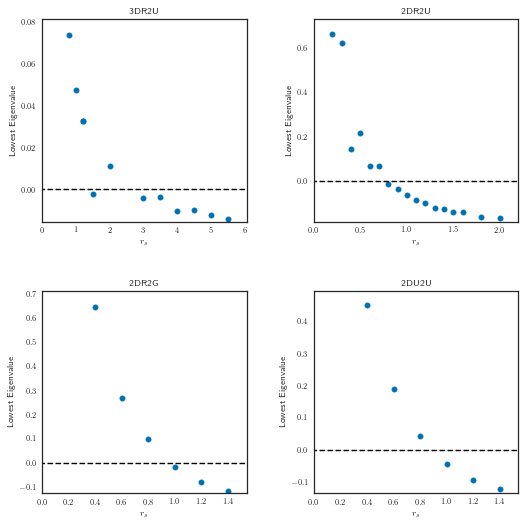

In [10]:
fig = plt.figure(figsize=(8, 8))

subview = dict_subview(data, ['2DR2U', '2DU2U', '2DR2G', '3DR2U'])
new_data = {key : HFSA.only_max(df, 'Nk', 'rs') for (key, df) in subview.items()}

HFSA.subplotByDfDict(new_data, fig, HFSA.plot_stability)
plt.tight_layout()
plt.show()

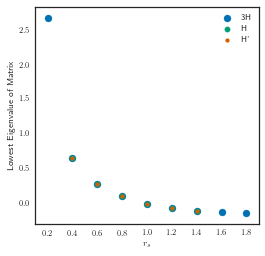

In [11]:
r2u = data['2DR2U'][data['2DR2U']['Nk'] == 33].sort_values(by='rs')
r2g = data['2DR2G'][data['2DR2G']['Nk'] == 33].sort_values(by='rs')
u2u = data['2DU2U'][data['2DU2U']['Nk'] == 33].sort_values(by='rs')

fig = plt.figure(figsize=(4, 4))
plt.scatter(r2u['rs'], r2u['dav_min_eval'], label="3H", s=50)
plt.scatter(r2g['rs'], r2g['dav_min_eval'], label='H', s=30)
plt.scatter(u2u['rs'], u2u['dav_min_eval'], label="H'", s=15)
plt.legend()
plt.ylabel('Lowest Eigenvalue of Matrix')
plt.xlabel('$r_s$')
plt.savefig('Matrix_Compare.pdf')
plt.show()

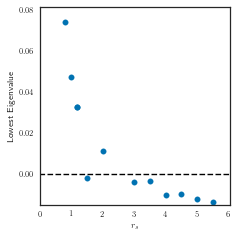

In [12]:
fig = plt.figure(figsize=(4, 4))
HFSA.plot_stability(HFSA.only_max(data['3DR2U'], 'Nk', 'rs'), fig.gca())
plt.tight_layout()
plt.show()

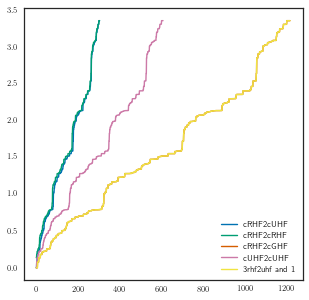

All within 1e-10? :  True


In [13]:
# load and scrub data
workdir = '/home/evan/git/HF-Stability/analysis/'
dfFactorTest =  HFSA.json_dir_to_df(workdir)

dfFactorTest.dropna(axis='rows', subset=['NDIM', 'rs', 'Nk', 'mycase', 'dav_min_eval'], inplace=True)
dfFactorTest['Nk'] = dfFactorTest['Nk'].astype(int)
dfFactorTest['NDIM'] = dfFactorTest['NDIM'].astype(int)
dfFactorTest['mycase'] = dfFactorTest['mycase'].astype(str)

evaldic = {dfFactorTest['mycase'].iloc[i] : dfFactorTest['exact_evals'].iloc[i] for i in range(len(dfFactorTest))}

fig = plt.figure()
for key, val in evaldic.items():
    plt.plot(range(len(val)), val, label=key)
    

sort = np.sort(np.concatenate([ evaldic['cRHF2cRHF']
                               ,evaldic['cRHF2cUHF']
                               ,evaldic['cRHF2cUHF']
                               ,evaldic['cRHF2cUHF'] ]))
plt.plot(range(len(sort)), sort, label='3rhf2uhf and 1')
plt.legend()
plt.show()

print("All within 1e-10? : ", np.all(np.abs(sort - evaldic['cRHF2cGHF']) < 1e-10))

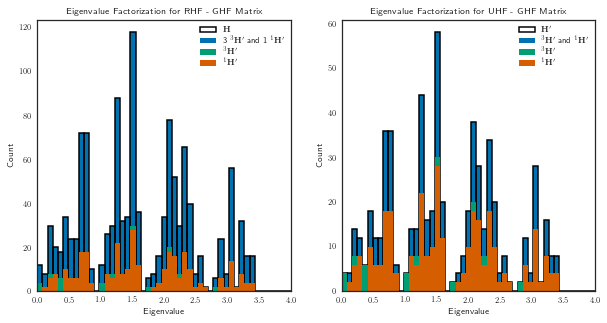

In [14]:
# the histogram of the data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
xmin, xmax = (0, 4)
binset = np.linspace(xmin, xmax, 50)
ax1.hist(evaldic['cRHF2cGHF'], bins=binset, histtype='bar', stacked=True, label="$\mathbf{H}$", fill=False, color='r'
        , linewidth=1.5, zorder=1)
ax1.hist(sort, bins=binset, histtype='bar', stacked=True, label="3 ${}^3\mathbf{H}'$ and 1 ${}^1\mathbf{H}'$", zorder=0)

ax1.hist(evaldic['cRHF2cUHF'], bins=binset, histtype='bar', stacked=True, label="${}^3\mathbf{H}'$")
ax1.hist(evaldic['cRHF2cRHF'], bins=binset, histtype='bar', stacked=True, label="${}^1\mathbf{H}'$")
ax1.set_title('Eigenvalue Factorization for RHF - GHF Matrix')
ax1.legend()
ax1.set_xlabel('Eigenvalue')
ax1.set_ylabel('Count')
ax1.set_xlim(xmin, xmax)

xmin, xmax = (0, 4)
binset = np.linspace(xmin, xmax, 50)
ax2.hist(evaldic['cUHF2cUHF'], bins=binset, histtype='bar', stacked=True, 
         label="$\mathbf{H}'$", fill=False, linewidth=1.5, zorder=1)
ax2.hist(np.concatenate([evaldic['cRHF2cUHF'], evaldic['cRHF2cRHF']]), 
         bins=binset, histtype='bar', stacked=True, label="${}^3\mathbf{H}'$ and ${}^1\mathbf{H}'$", 
         color=sns.color_palette()[0], zorder=0)

ax2.hist(evaldic['cRHF2cUHF'], bins=binset, histtype='bar', stacked=True, label="${}^3\mathbf{H}'$", color=sns.color_palette()[1])
ax2.hist(evaldic['cRHF2cRHF'], bins=binset, histtype='bar', stacked=True, label="${}^1\mathbf{H}'$", color=sns.color_palette()[2])
ax2.set_xlim(xmin, xmax)
ax2.set_title('Eigenvalue Factorization for UHF - GHF Matrix')
ax2.legend()
ax2.set_xlabel('Eigenvalue')
ax2.set_ylabel('Count')
plt.savefig('matrix_factor_histograms.pdf')
plt.show()

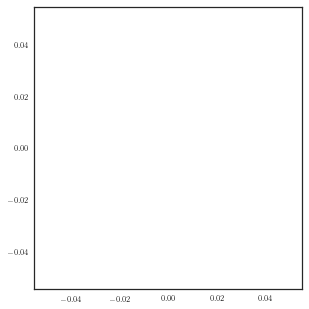

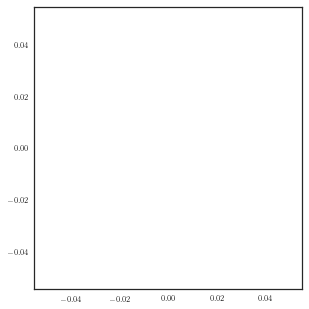

In [15]:
fig = plt.figure()
df1dmax = data['1DR2R'][data['1DR2R']['Nk'] == 142]
plt.scatter(df1dmax['rs'], df1dmax['full_diag_min'])
plt.tight_layout()
plt.show()

fig = plt.figure()
df1dmax = data['1DR2U'][data['1DR2U']['Nk'] == 142]
plt.scatter(df1dmax['rs'], df1dmax['full_diag_min'])
plt.tight_layout()
plt.show()

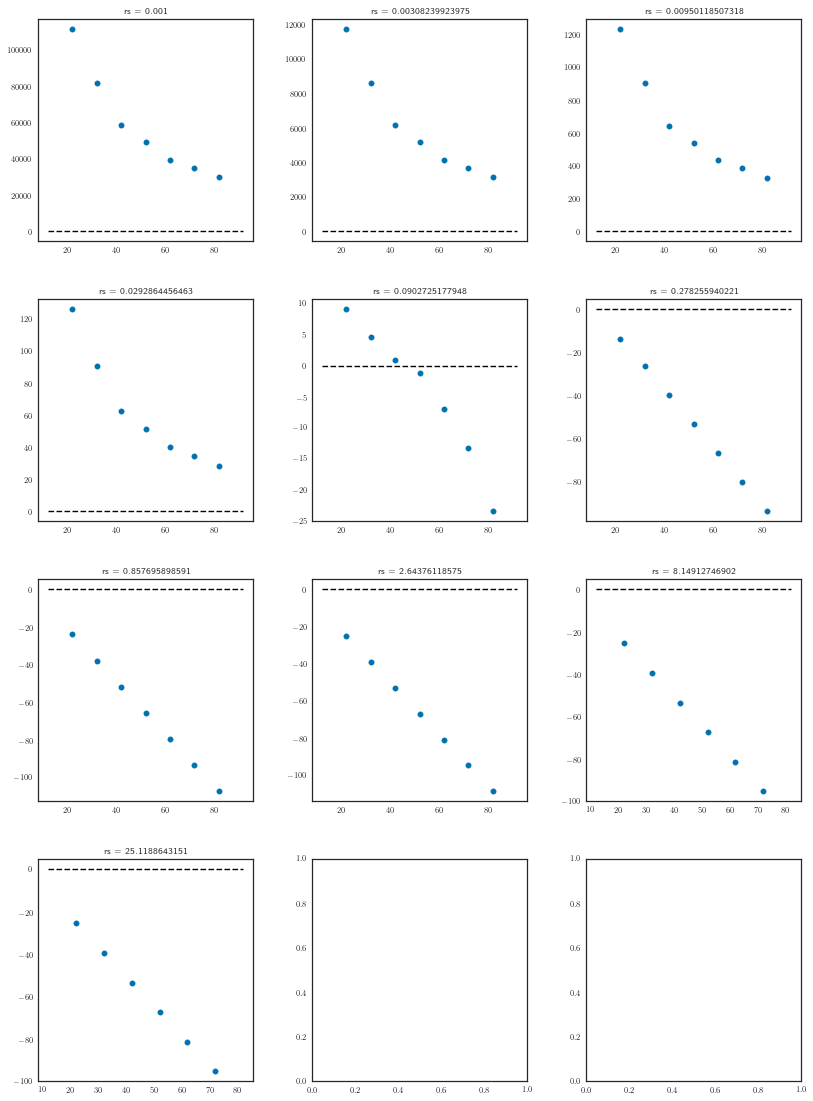

In [16]:
gp = data['1DR2U'].groupby('rs')

nrows, ncols = HFSA.get_square_tuple(N=len(gp))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
loc = [i[0] for i in np.ndenumerate(axes)]

count = 0
called = False

def eval_convergence(df, groupby=None):
    global count
    global called
    if called:
        ax = axes[loc[count][0], loc[count][1]]
        Nk = df.sort_values('Nk')['Nk']
        fullmin = df.sort_values('Nk')['full_diag_min']
        ax.scatter(Nk, fullmin)
        ax.set_title('rs = ' + str(df['rs'].iloc[0]))
        xmin = np.min(df['Nk']) - 10
        xmax = np.max(df['Nk']) + 10
        N = 100
        ax.plot(np.linspace(xmin, xmax, N), np.zeros(N), 'k--')
        count += 1
    else:
        called = True
        
gp.apply(eval_convergence, gp)
plt.tight_layout()
plt.show()

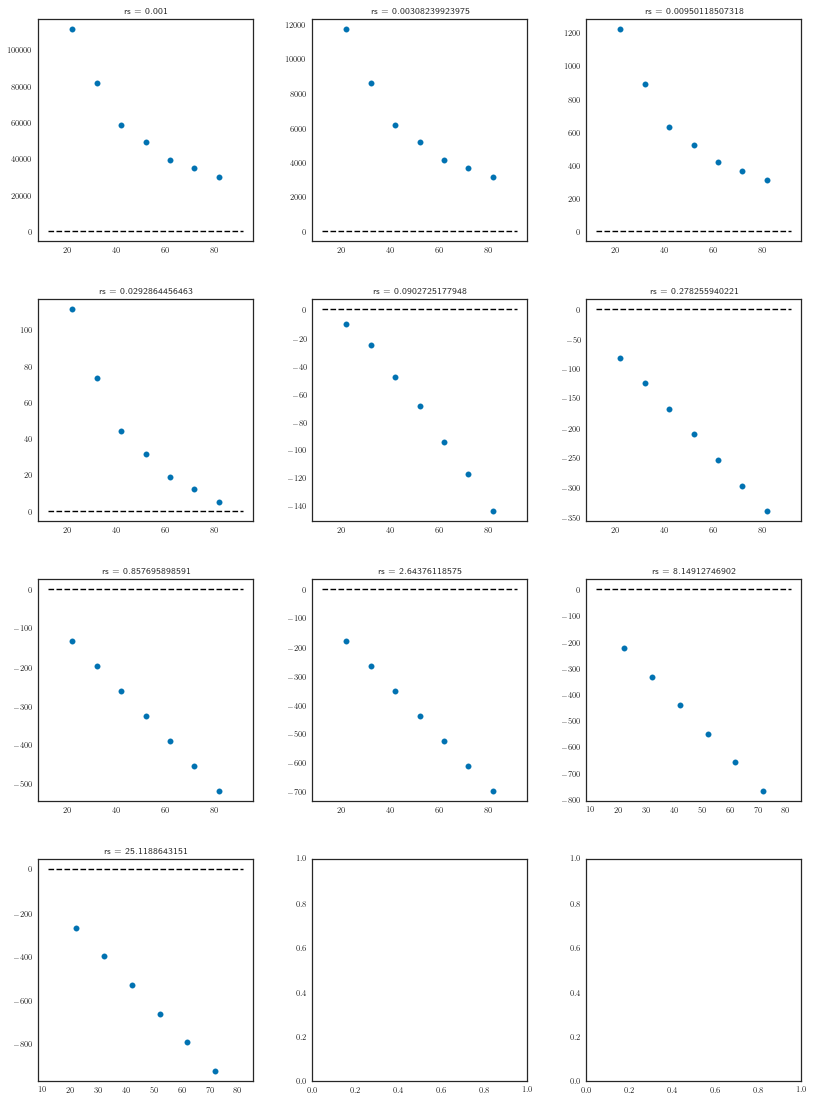

In [17]:
gp = data['1DR2R'].groupby('rs')

nrows, ncols = HFSA.get_square_tuple(N=len(gp))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
loc = [i[0] for i in np.ndenumerate(axes)]

count = 0
called = False

def eval_convergence(df, groupby=None):
    global count
    global called
    if called:
        ax = axes[loc[count][0], loc[count][1]]
        Nk = df.sort_values('Nk')['Nk']
        fullmin = df.sort_values('Nk')['full_diag_min']
        ax.scatter(Nk, fullmin)
        ax.set_title('rs = ' + str(df['rs'].iloc[0]))
        xmin = np.min(df['Nk']) - 10
        xmax = np.max(df['Nk']) + 10
        N = 100
        ax.plot(np.linspace(xmin, xmax, N), np.zeros(N), 'k--')
        count += 1
    else:
        called = True
        
gp.apply(eval_convergence, gp)
plt.tight_layout()
plt.show()

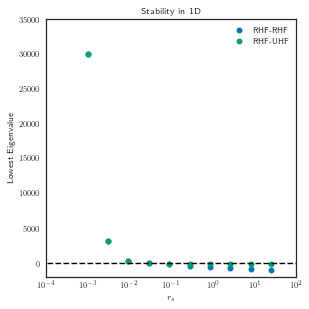

In [18]:
dfr2rmax = HFSA.only_max(data['1DR2R'], maximize='Nk', unique='rs')
dfr2umax = HFSA.only_max(data['1DR2U'], maximize='Nk', unique='rs')

fig = plt.figure()
plt.scatter(dfr2rmax['rs'], dfr2rmax['full_diag_min'], label='RHF-RHF')
plt.scatter(dfr2umax['rs'], dfr2umax['full_diag_min'], label='RHF-UHF')
plt.plot(np.linspace(0, 100, 50), np.zeros(50), 'k--')
plt.xscale('log')
plt.xlim(1e-4, 1e2)
plt.ylim(-2000, 35000)
plt.xlabel('$r_s$')
plt.ylabel('Lowest Eigenvalue')
plt.title('Stability in 1D')
plt.legend()
plt.tight_layout()
plt.savefig('1dstab.pdf')
plt.show()

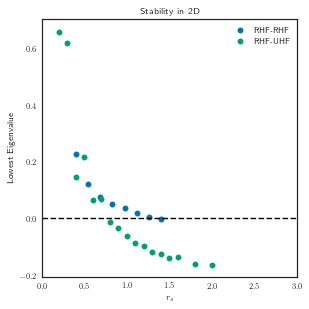

In [19]:
dfr2rmax = HFSA.only_max(data['2DR2R'], maximize='Nk', unique='rs')
dfr2umax = HFSA.only_max(data['2DR2U'], maximize='Nk', unique='rs')

fig = plt.figure()
plt.scatter(dfr2rmax['rs'], dfr2rmax['dav_min_eval'], label='RHF-RHF')
plt.scatter(dfr2umax['rs'], dfr2umax['dav_min_eval'], label='RHF-UHF')
plt.plot(np.linspace(0, 100, 50), np.zeros(50), 'k--')
#plt.xscale('log')
plt.xlim(1e-4, 3)
#plt.ylim(-2000, 35000)
plt.xlabel('$r_s$')
plt.ylabel('Lowest Eigenvalue')
plt.title('Stability in 2D')
plt.legend()
plt.tight_layout()
plt.savefig('2dstab.pdf')
plt.show()

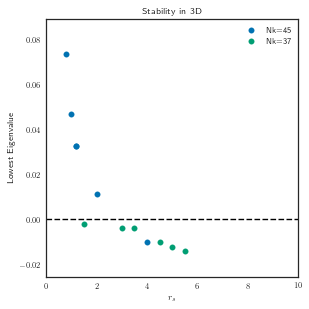

In [37]:
#dfr2rmax = HFSA.only_max(data['3DR2R'], maximize='Nk', unique='rs')
dfr2umax = HFSA.only_max(data['3DR2U'], maximize='Nk', unique='rs')
dfr2umax45 = dfr2umax[dfr2umax['Nk'] == 45]
dfr2umax37 = dfr2umax[dfr2umax['Nk'] == 37]
fig = plt.figure()
#plt.scatter(dfr2rmax['rs'], dfr2rmax['full_diag_min'], label='RHF-RHF')
plt.scatter(dfr2umax45['rs'], dfr2umax45['dav_min_eval'], label='Nk=45')
plt.scatter(dfr2umax37['rs'], dfr2umax37['dav_min_eval'], label='Nk=37')
plt.plot(np.linspace(0, 100, 50), np.zeros(50), 'k--')
#plt.xscale('log')
plt.xlim(1e-4, 10)
#plt.ylim(-2000, 35000)
plt.xlabel('$r_s$')
plt.ylabel('Lowest Eigenvalue')
plt.title('Stability in 3D')
plt.legend()
plt.tight_layout()
plt.savefig('3dstab.pdf')
plt.show()

In [36]:
dfr2umax['Nk']

277    45
588    45
277    45
64     37
586    45
585    45
209    45
174    37
429    37
503    37
566    37
596    37
Name: Nk, dtype: int64